In [ ]:
!pip install -q transformers
!pip install -q datasets

# Part 0 - Imports and datasets loading

In [110]:
import pandas as pd
from datasets import load_dataset
from transformers import pipeline
from tqdm import tqdm
from sklearn.metrics import classification_report
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import random
from tqdm.auto import tqdm
random.seed(1)

In [114]:
tqdm.pandas()

In [3]:
dataset = load_dataset('emotion')

print (dataset.column_names)
print (len(dataset['train']), len(dataset['validation']), len(dataset['test']))

#labels in this dataset
emotions=['sadness','joy','love','anger','fear','surprise']
reverse_emotions = {emotions[i]:i for i in range(len(emotions))}

Using custom data configuration default


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to C:\Users\ddd\.cache\huggingface\datasets\emotion\default\0.0.0\348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

{'train': ['text', 'label'], 'validation': ['text', 'label'], 'test': ['text', 'label']}
16000 2000 2000


Part 1 - Perform EDA on the dataset.

Try answering questions like - 
* What is the distribution of labels in the dataset?
* What is the distribution of the length of the texts?
* What is the distribution of words per class? (you can use the wordcloud dataset for visualization)

In [45]:
dataset.data['train'].to_pandas()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


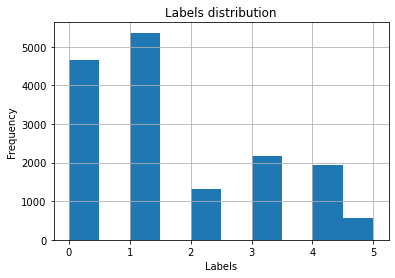

In [68]:
dataset.data['train'].to_pandas().label.hist()

plt.title('Labels distribution')
plt.xlabel('Labels')
plt.ylabel('Frequency');
plt.show()

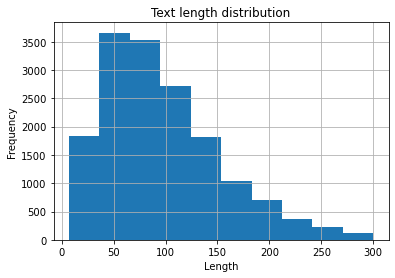

In [67]:
dataset.data['train'].to_pandas().text.str.len().hist()

plt.title('Text length distribution')
plt.xlabel('Length')
plt.ylabel('Frequency');
plt.show()

In [97]:
%%time

eng_stopwords = stopwords.words('english')
all_words = pd.Series(' '.join(dataset.data['train'].to_pandas().text).split())
all_words[all_words.apply(lambda word:  word not in eng_stopwords)].value_counts()[:10]

Wall time: 980 ms


feel       11183
feeling     5112
like        2908
im          2430
really       942
know         853
time         794
get          740
little       736
people       654
dtype: int64

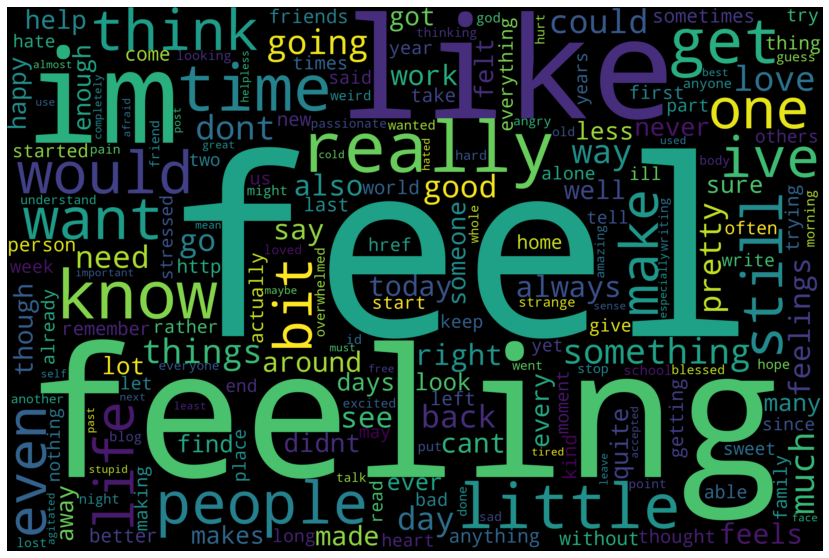

Wall time: 21.5 s


In [98]:
%%time


wordcloud = WordCloud(width = 3000, height = 2000,collocations=False).generate_from_frequencies(all_words[all_words.apply(lambda word:  word not in eng_stopwords)].value_counts())
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Part 2 - Finetune a LM on the emotions dataset

In this section you are required to fine tune a LM using the transformers package on the emotions dataset, for refernce you may assist with Hugging Face's notebooks.

In [101]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [99]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [ ]:
tokenized_db = dataset.map(preprocess_function, batched=True)

In [102]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=6)

In [ ]:
%%time

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_db["train"],
    eval_dataset=tokenized_db["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

# Part 3 - zero-shot classification using prompts

It turns out that prompting can be used not only on huge LM but also on small/medium-sized LM. The idea is fairly simple and it utilizes the masked language loss that the model was trained on. The process goes like this: 

Assume that we have a sentiment analysis task in hand. To classify the following sentence:

* I didn't enjoy the movie at all.

We will modify the input sentence with a prompt:

* I didn't enjoy the movie at all. The movie was \<MASK\>

The modified sentence will be used as an input for the model. The model (which was trained to complete masked words) will output candidates for the masked word. 

* terrible

Now, how can we use that word?

We will have to keep a mapping that will translate the word "terrible" to one of our labels in this case negative


In this part, you are required to implement the above method and compare it to the fully fine-tuned model from part 1



#Bonus 1

As you might noticed this is a vanilla approach on how we can utilize prompting to fine tune LM. There is a lot of room for improvment

Come up with idea\s on how you can improve the above method


#Bonus 2

Implement one of your ideas